This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_tellurium_ex
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 50.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 1000, 10000])

k11 = 0.1
k12 = 0.11

test1 = Test(model=model_tellurium_ex(mods={'k1': k11}), stochastic=True, **test_kwargs)
test2 = Test(model=model_tellurium_ex(mods={'k1': k12}), stochastic=True, **test_kwargs)
tests = [test1, test2]

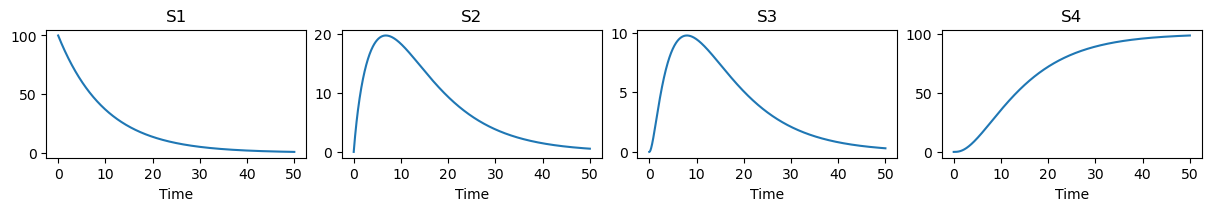

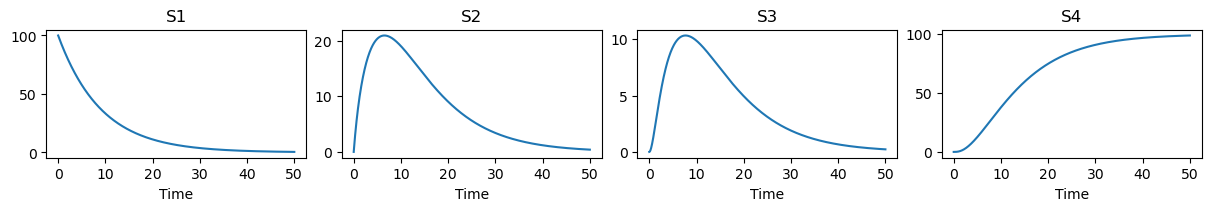

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

sr.start_pool()
for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

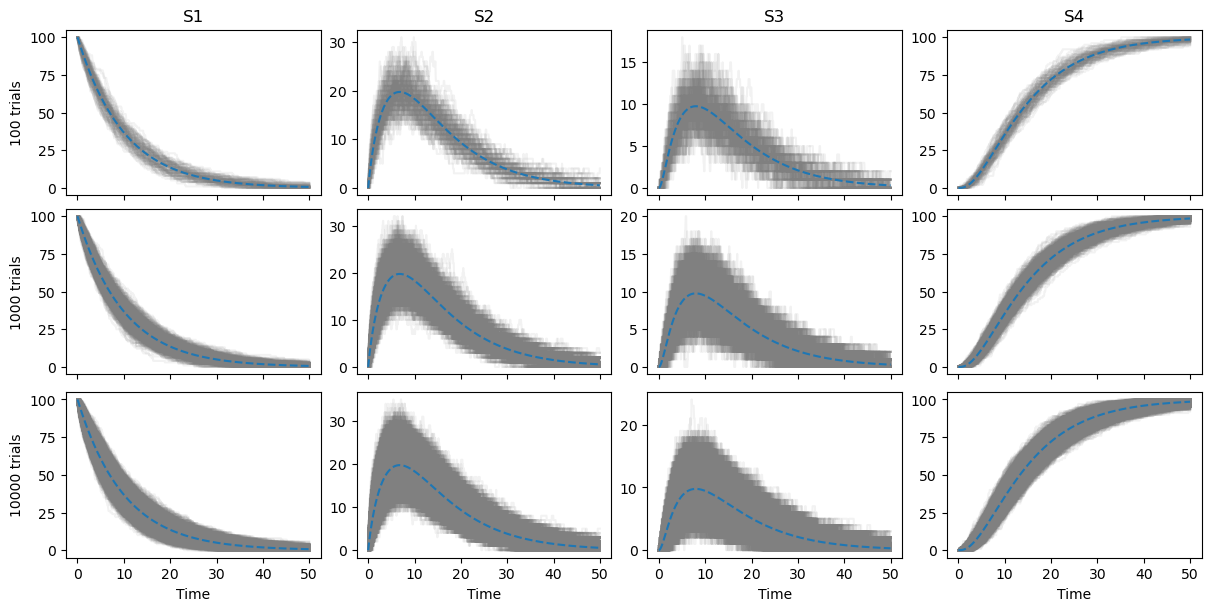

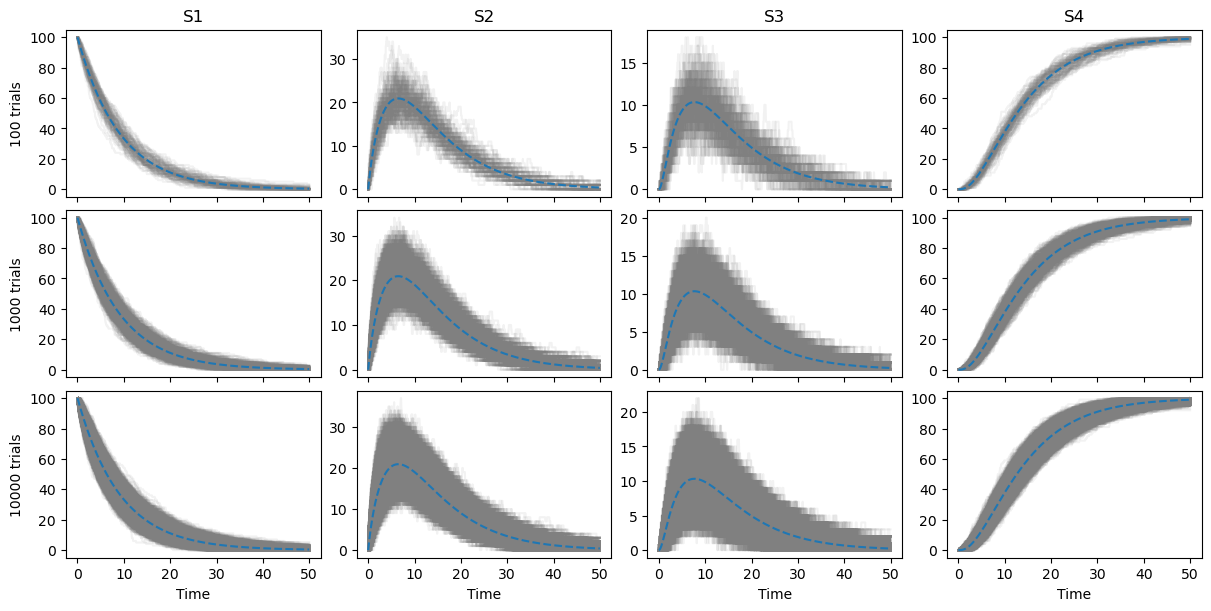

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

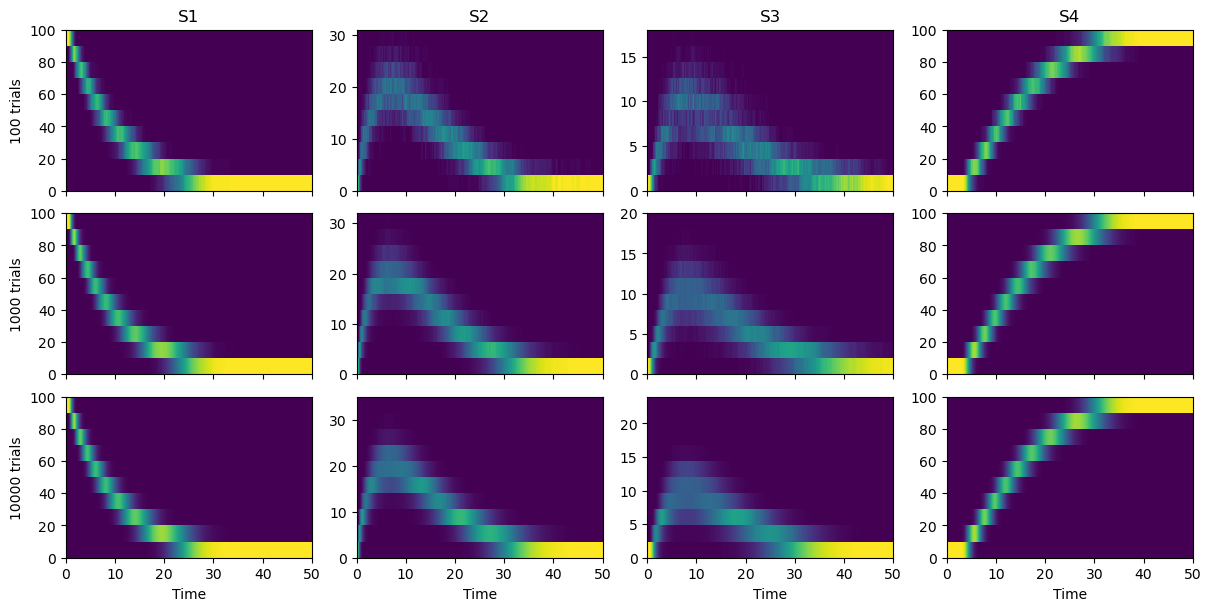

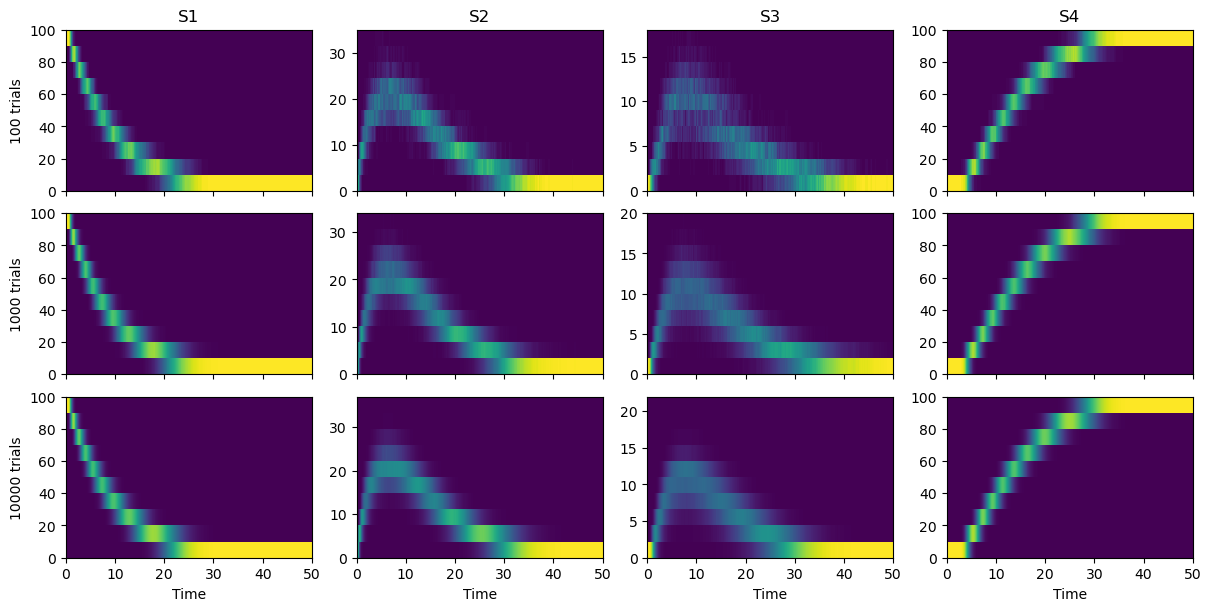

In [5]:
for test in tests:
    _ = test.plot_distributions()

/Users/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:992: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


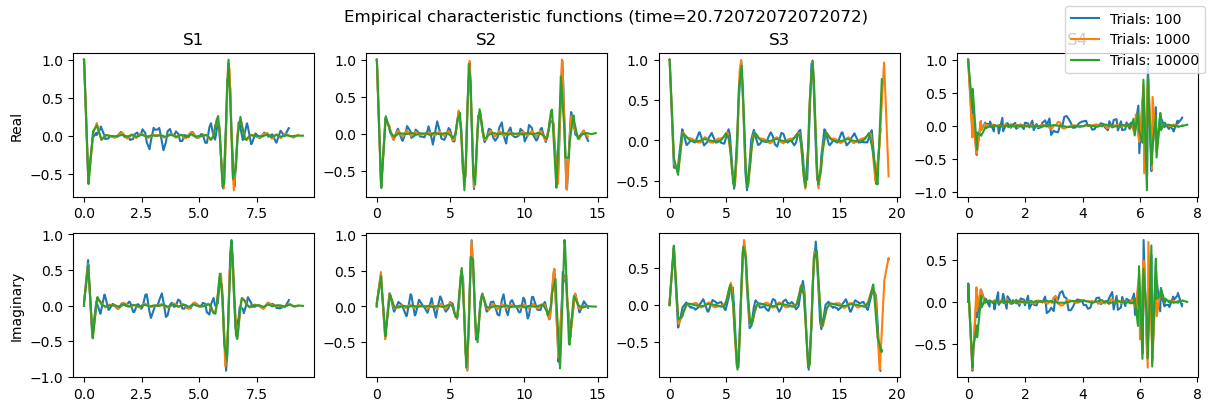

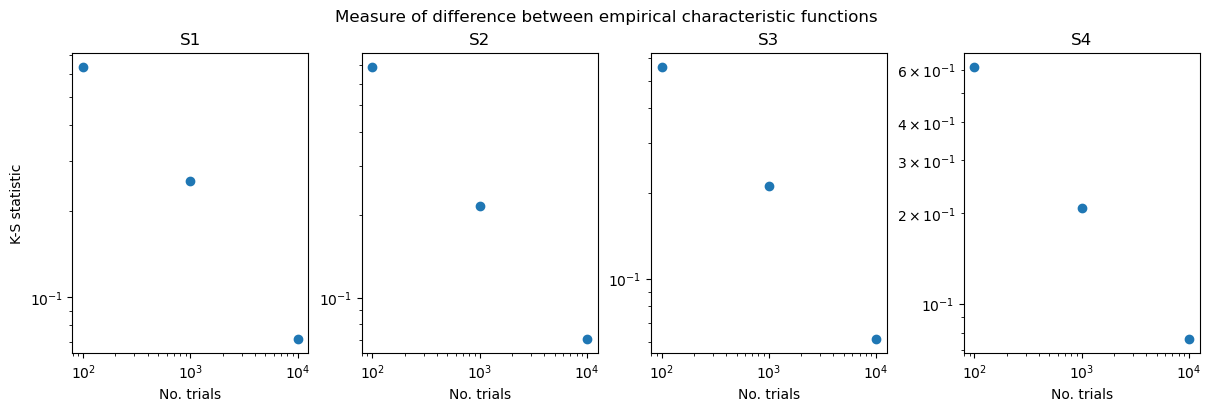

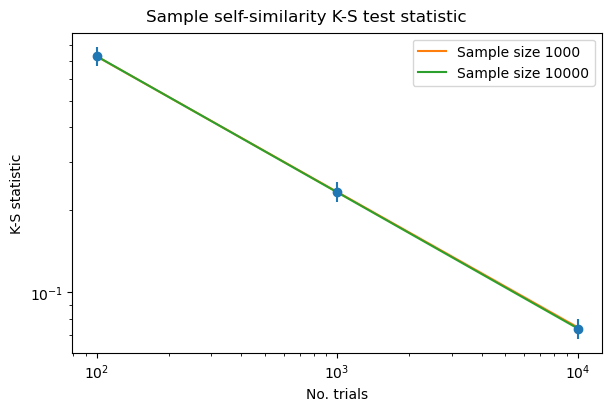

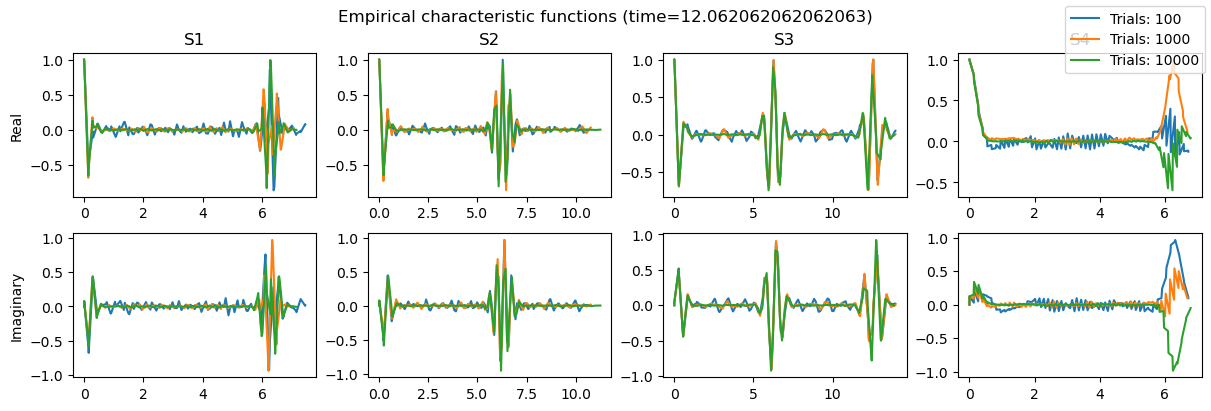

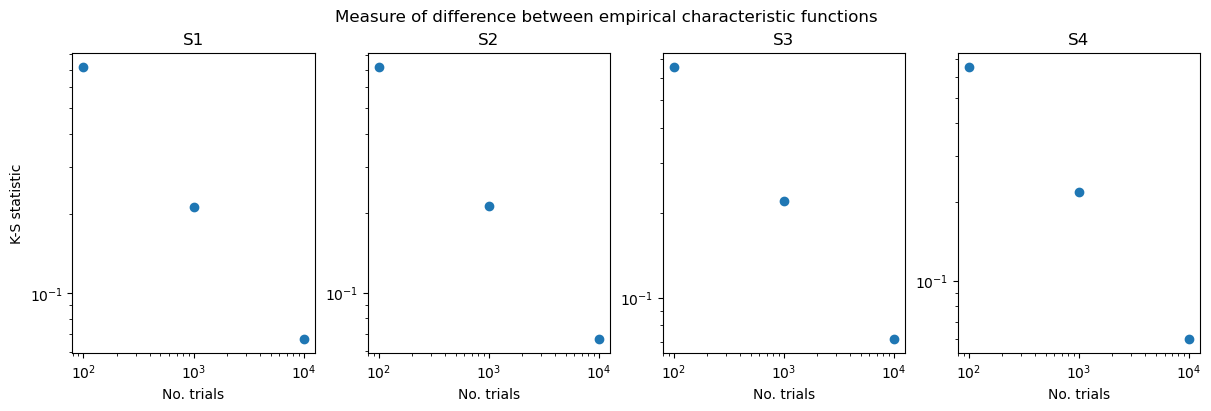

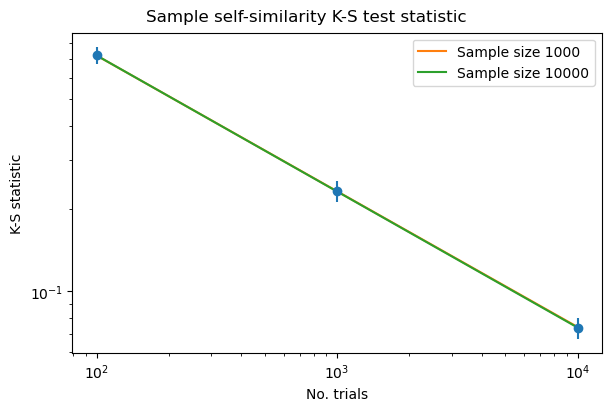

In [6]:
# Runtime: ~322 minutes (Precision laptop)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

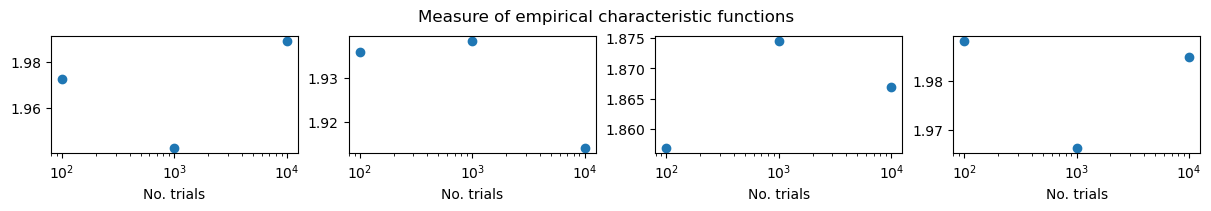

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in model parameters. 

Output()

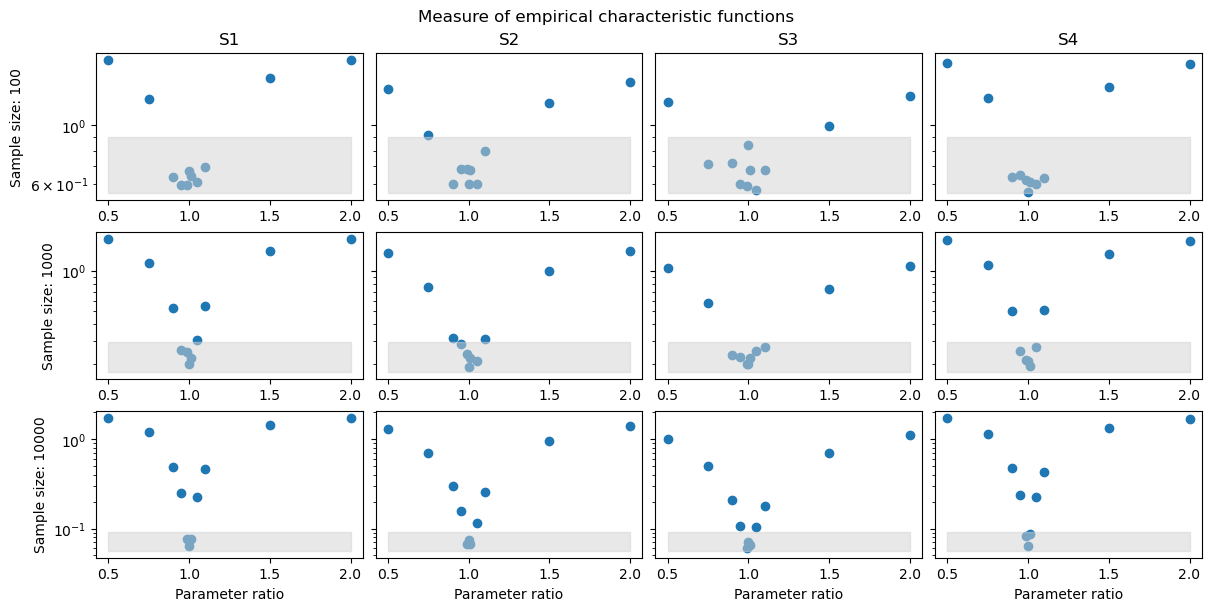

In [9]:
k1_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
k1_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in k1_fact:
    label.value = f'Factor: {bf}...'

    k1test = k11 * bf
    test = Test(model=model_tellurium_ex(mods={'k1': k1test}), stochastic=True, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    k1_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(k1_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in k1_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(k1_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('Measure of empirical characteristic functions')

In [11]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'Error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in k1_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(k1_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.726275,0.057616
1000,0.232805,0.019404
10000,0.073851,0.005949


Sample size  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                
100         0.50           1.758590  17.917116         0.019608                    100   
            0.75           1.266610  9.378192          0.019608                    100   
            0.90           0.719981 -0.109241          1.000000                    100   
            0.95           0.680000 -0.803166          1.000000                    100   
            0.99           0.680000 -0.803163          1.000000                    100   
            1.00           0.839717  1.968916          0.274510                    100   
            1.01           0.679722 -0.807988          1.000000                    100   
            1.05           0.610938 -2.001820          1.000000                    100   
            1.10           0.800000  1.279584          0.627451                    100   
            1.50           1.499995  13.428871         0.019608                    100   
            2.00           1.765951  18.044874         0.019608                    100   
1000        0.50           1.734451  77.386946         0.001996                   1000   
            0.75           1.153198  47.432242         0.001996                   1000   
            0.90           0.525609  15.089602         0.005988                   1000   
            0.95           0.283999  2.638280          0.145709                   1000   
            0.99           0.245756  0.667457          1.000000                   1000   
            1.00           0.211753 -1.084884          1.000000                   1000   
            1.01           0.224000 -0.453779          1.000000                   1000   
            1.05           0.305159  3.728732          0.073852                   1000   
            1.10           0.544545  16.065451         0.003992                   1000   
            1.50           1.421144  61.240760         0.001996                   1000   
            2.00           1.745892  77.976538         0.001996                   1000   
10000       0.50           1.741353  280.308173        0.000200                  10000   
            0.75           1.185650  186.894152        0.000200                  10000   
            0.90           0.493577  70.556250         0.000400                  10000   
            0.95           0.249050  29.450977         0.001200                  10000   
            0.99           0.082185  1.400846          0.512298                  10000   
            1.00           0.074781  0.156263          1.000000                  10000   
            1.01           0.087289  2.258929          0.196961                  10000   
            1.05           0.226573  25.672687         0.001600                  10000   
            1.10           0.462732  65.371058         0.000400                  10000   
            1.50           1.424095  226.976955        0.000200                  10000   
            2.00           1.741918  280.403183        0.000200                  10000   

                                                                           Scaling factor  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                   
100         0.50           1.758590  17.917116         0.019608                      0.50   
            0.75           1.266610  9.378192          0.019608                      0.75   
            0.90           0.719981 -0.109241          1.000000                      0.90   
            0.95           0.680000 -0.803166          1.000000                      0.95   
            0.99           0.680000 -0.803163          1.000000                      0.99   
            1.00           0.839717  1.968916          0.274510                      1.00   
            1.01           0.679722 -0.807988          1.000000                      1.01   
            1.05           0.610938 -2.001820          1.000000                      1.